In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import seaborn as sns

####
import scipy.io
import scipy.stats as stats
import scipy.signal as signal
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import pywt

####
import seaborn as sns

import matplotlib.pyplot as plt

####
from sklearn.impute import SimpleImputer
from sklearn.isotonic import IsotonicRegression
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score, matthews_corrcoef, roc_auc_score, average_precision_score, log_loss
from sklearn.cluster import SpectralClustering 
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, LeaveOneOut
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.inspection import permutation_importance

###
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.generators import random_walk_blobs, random_walks
from tslearn.utils import to_time_series_dataset, to_sklearn_dataset
from tslearn.shapelets import LearningShapelets
from tslearn.clustering import KShape

###
from astropy.stats import jackknife_stats

###
from statsmodels.tsa.stattools import acf

###
import emd 

###
import tensorflow as tf

####
from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

###
import itertools
import sys

###
from ECG_data import ECG_Dataset
import Main_Repository as MR

2024-09-30 12:23:35.951179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
####################
### console room ###
####################

#kind of data
kind = "AF"

#wheater to use fictious data
testing_modality= False
load_ecg_data = True

#wheater to fit the model
fit_flag= False


#whether to enable the instances' reconstructions
flag_reconstructions= False

#check the reconstructions' prediction?
flag_recs_prediction = False

#check KAR and ROAR?
flag_kar_roar= False

#make sensitivity analysis on time?
flag_time_dep_analysis= False

#
flag_inspection = False

#
flag_comlete_model= True

In [3]:
###call classes
cnn1d = MR.CNN_1D()
deconv_1d = MR.DeconvFeatMap()
utils = MR.Tools()

In [4]:
###load the AF data


if testing_modality:
    
    X, Y = random_walk_blobs(n_blobs=2, d=5, noise_level=.1, random_state=6)
    params = [8, 3, 2]
    
    ####Make split
    X, U, Y, V = train_test_split(X, Y, train_size=.5, random_state=6)

    #use smoteenn
    X, Y = cnn1d.use_SMOTEENN(X, Y)
    #use smoteenn
    #U, V = cnn1d.use_SMOTEENN(U, V)


else:
    
    if load_ecg_data:
    
        ### ### ### ### ### ### ### ### ### ### ### ### ### ###
        if kind == "AF":
            dict_vals = ECG_Dataset().Arithmia_dataset(downsampling= 10)
        elif kind == "MI":
            dict_vals = ECG_Dataset().Myocardial_infarction_dataset(downsampling= 10)
        elif kind == "SB":
            dict_vals = ECG_Dataset().Sinus_Bradycardia_dataset(downsampling= 10)    

        ####PRE-PROCESSING
        ###get all the data
        X, Y = dict_vals['data'], dict_vals['labels'] 

        ###just maintain the Time-Series scale, but reduce its energy
        X= X*1e-3

        ###0 mean + apotizzation
        for ii in range(X.shape[0]):
            for jj in range(X.shape[-1]):
                X[ii, :, jj] = (X[ii, :, jj] - X[ii, :, jj].mean() )*signal.tukey(X.shape[1], alpha= 10e-2)


        ### the data that do not belong to one of the two classes are marked with "-1"
        #### DIscard data with the "-1" mark!!!
        age , sex = dict_vals['age'][Y!=-1], dict_vals["sex"][Y!=-1]
        ###
        print("mean age:", age.mean())
        print("std age:", age.std())
        norm_age = (age-age.mean())/age.std()
        
        ####
        baseline = np.vstack([norm_age, sex]).T

        X, Y = X[Y!=-1], Y[Y!=-1]

        ###Set to 0 all makes = -1
        Y[Y==-1] = 0

        #### Name Feautres
        name_feats = dict_vals["name_features"]
    
        ####Make split
        X, U, Y, V = train_test_split(X, Y, train_size=.5, random_state=6)
        
        
        B_x, B_u = train_test_split(baseline, train_size=.5, random_state=6)
        print(X.shape, B_x.shape, U.shape, B_u.shape)
        
        #use smoteenn
        X, Y = cnn1d.use_SMOTEENN(X, Y)
        #use smoteenn
        #U, V = cnn1d.use_SMOTEENN(U, V)

45152 45152
mean age: 58.02486622599937
std age: 16.755461001463686
(4765, 500, 12) (4765, 2) (4766, 500, 12) (4766, 2)


In [5]:
if fit_flag:
    
    ### ### ### ### ### ### ### ### ### ### ### ### ### ###
    if kind == "AF":
        params = [32, 5, 2]
    elif kind == "MI":
        params = [32, 5, 3]
    elif kind == "SB":
        params = [32, 9, 4]
    

    ###get the params
    filt_, ks_, depth_ = params

    ###define the model
    model_ = cnn1d.CNN_1D(X, 
                       filters= filt_,
                       kernel_size=ks_, 
                       deepness= depth_,
                       DropOut = 0,
                       dense_units=1,
                       activation='relu',
                       semi_ortho_constraint= True,
                       bias=False)

    ####
    dict_fit = cnn1d.one_held_out_validation(X, Y, model_, 
                                               verbose=None, 
                                               risk_score= True, 
                                               use_SMOTEENN= False, 
                                               patience= 5
                                               )
    
    #Save_some_stuff
    Xtest, Ytest = dict_fit['Test_Data']

    #save the data
    np.savez('Test_Data_ECG_results_'+str(kind)+'.npz', data= Xtest, labels= Ytest)
    np.savez('Test_Data_ECG_LR_results_'+str(kind)+'.npz', data= U, labels= V)
    
    #save the model
    tf.keras.models.save_model(model_, 'model_ECG_results_'+str(kind)+'.h5')
    
else:
    archive = np.load('Test_Data_ECG_results_'+str(kind)+'.npz')
    Xtest = archive['data']
    Ytest = archive['labels']
    #
    archive_lr = np.load('Test_Data_ECG_LR_results_'+str(kind)+'.npz')
    U = archive_lr['data']
    V = archive_lr['labels']
    model_ = tf.keras.models.load_model('model_ECG_results_'+str(kind)+'.h5', 
                                       compile=False, 
                                       custom_objects={'SemiOrthogonal': MR.SemiOrthogonal})

In [6]:
if flag_reconstructions:

    ###et the Reconstructions
    RECS = deconv_1d.Reconstruction(Xtest, CNNmodel= model_)

    ##get Saliency Map
    SMs = deconv_1d.SaliencyMap(Xtest, 
                                RECS,
                                CNNmodel= model_, 
                                Y= Ytest, 
                                activation='relu', 
                                )

    ###save_some_stuff
    np.savez('Test_Data_Reconstructions'+str(kind)+'.npz', RECS= RECS, SMs= SMs)

else:
    
    archive_recs = np.load('Test_Data_Reconstructions'+str(kind)+'.npz')
    RECS = archive_recs["RECS"]
    SMs = archive_recs["SMs"]

In [7]:
#1. Check if reconstructions are still predictive?
if flag_recs_prediction:
    
    ##evalate reconstructions
    #kfold_rec = ShuffleSplit(n_splits=20, test_size=.2)
    #kfold_rec = L(n_splits=10)
    kfold_rec = LeaveOneOut()
    box = []
    c = 0
    for index_train, index_test in kfold_rec.split(Xtest):
        
        ### ### ###
        REC_train = RECS[index_train]#deconv_1d.Reconstruction(Xtest[index_test], CNNmodel= model_)

        ###make predictions with reconstructions
        rec_predictions = model_.predict(REC_train, verbose=None)

        auroc = roc_auc_score(y_score = rec_predictions, 
                      y_true = Ytest[index_train])

        auprc = average_precision_score(y_score = rec_predictions, 
                                          y_true = Ytest[index_train])

        mcc = matthews_corrcoef(y_pred= (rec_predictions>=.5).astype(int), y_true= Ytest[index_train])

        ####append results
        box.append([auroc, auprc, mcc, .5*auroc*auprc*(mcc+1)])


    ###get the average estimation
    rec_metrics = np.apply_along_axis(jackknife_stats, axis= 0, arr= np.array(box), statistic= np.mean)[[0, 2]].astype(float)

    ###save the results
    df_rec = pd.DataFrame(rec_metrics, columns=["AUROC", "AUPRC", "MCC", "3MCS"], 
                 index= ["Mean", "SEM"])

    if testing_modality == False:
        df_rec.to_csv("imgs_for_paper/ECG_Prediction_of_Reconstructions_"+str(kind)+'.csv')
        
    #visualize
    df_rec

In [8]:
if flag_kar_roar:

    ###Evaluate KAR
    #res_kar, res_rnd = utils.KAR(Xtest, 
    #                             Ytest, 
    #                             SMs, 
    #                             model_, 
    #                             metric="AUROC")
    #kar_mcc, kar_mcc_err = res_kar 
    #kar_rnd_mcc , kar_rnd_mcc_err = res_rnd
    #dg = pd.DataFrame(np.vstack([kar_mcc, kar_mcc_err, kar_rnd_mcc, kar_rnd_mcc_err]).T, 
    #                  columns= ["KAR", "KAR_err", "Keep_at_Random", "Keep_at_Random_err"])

    #if testing_modality== False:
    #    dg.to_csv("imgs_for_paper/ECG_KAR_"+str(kind)+'.csv', sep= ';')

    ### Evaluate ROAR
    res_roar, res_rnd= utils.ROAR(Xtest, Ytest, SMs, model_, metric="AUROC")

    roar_mcc, roar_mcc_err = res_roar
    roar_rnd_mcc , roar_rnd_mcc_err = res_rnd
    dg = pd.DataFrame(np.vstack([roar_mcc, roar_mcc_err, roar_rnd_mcc, roar_rnd_mcc_err]).T)

    dg = pd.DataFrame(np.vstack([roar_mcc, roar_mcc_err, roar_rnd_mcc, roar_rnd_mcc_err]).T, 
                      columns= ["ROAR", "ROAR_err", "Remove_at_Random", "Remove_at_Random_err"])

    if testing_modality== False:
        dg.to_csv("imgs_for_paper/ECG_ROAR_"+str(kind)+'.csv', sep= ';')
            

In [9]:
if flag_time_dep_analysis:
    
    ####Make an analysis dependent on the time_scale
    time_scales= [5e-2, .1, .2, .5]
    smotenn = SMOTEENN(sampling_strategy=1)

    for metric in ["roc_auc", "average_precision", "matthews_corrcoef"]:

        ###looop over the number of kshape
        for number_of_kshapes in [4, 8, 16, 32] :
            
            results= []
            results_err= []
            
            ###loop over the different time-scales
            for time_scale in time_scales:

                ###get the most salient patterns
                most_salient_patterns = utils.Most_Salient_Pattern(Xtest[Ytest==1], 
                                                                       SMs[Ytest==1].mean(axis= -1),
                                                                       time_scale=time_scale)


                #number_of_kshapes= utils.Optimal_number_of_components(X= Xtest[Ytest==1], 
                #                                Y= Ytest[Ytest==1], 
                #                                Z = SMs[Ytest==1].mean(axis= -1), 
                #                                use_smoteenn= False,
                #                                plot_results= False,
                #                                print_results=True,
                #                                save_plot= False)

                #number_of_kshapes= 16

                ###extract the Kpatterns
                kpattern, __ = utils.find_K_patterns(most_salient_patterns, number_of_kshapes)

                ###get the new features
                feat = utils.min_distance_feature(U, kpattern)
                #use any survial function to let relevant presencevalues to be closer to unity
                #feat = np.exp(-feat)
                                
                #
                kpca = KernelPCA(n_components= number_of_kshapes, 
                            kernel= "rbf")
                
                feat = kpca.fit_transform(feat)

                ####
                try:
                    new_x, new_y = smotenn.fit_resample(feat, V)
                except:
                    new_x, new_y = feat.copy(), V.copy()

                ####make prediction for AUROC
                lr = LogisticRegressionCV(Cs= [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5], 
                                               scoring=metric, 
                                                  cv= 5, 
                                                  class_weight = 'balanced',
                                                  fit_intercept=True, 
                                                  random_state=16)
                lr.fit(new_x, new_y)

                results_jack = np.apply_along_axis(jackknife_stats, axis= 0, arr= lr.scores_[1], statistic= np.mean)
                results.append(results_jack[0])
                results_err.append(results_jack[2])


            print(np.vstack(results))
            
            ###
            dresults = pd.DataFrame(np.vstack(results), 
                                    columns= [r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", 
                                              "1", "10", r"$10^{2}$", r"$10^{3}$", r"$10^{4}$", r"$10^{5}$"],
                                            index = ["0.5", "1", "2", "4"])
            
            dresults_err = pd.DataFrame(np.vstack(results_err), 
                                            columns= [r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", 
                                              "1", "10", r"$10^{2}$", r"$10^{3}$", r"$10^{4}$", r"$10^{5}$"],
                                            index = ["0.5", "1", "2", "4"])

            if testing_modality== False:
                dresults.to_csv("imgs_for_paper/ECG_Time_Window_predictions_sensitivity_analysis_KS_"+str(number_of_kshapes)+"_"+metric+"_"+kind+'.csv')

            if testing_modality== False:
                dresults_err.to_csv("imgs_for_paper/ECG_Time_Window_predictions_sensitivity_analysis_SEM_KS_"+str(number_of_kshapes)+"_"+metric+"_"+kind+'.csv')

if flag_time_dep_analysis:
    print("RESULTS")
    print(dresults)
    print("***** ***** ***** ***** *****")
    print("RESULTS_err")
    print(dresults_err)

In [10]:
###inspection
if flag_inspection:
    
    ###sensitivity anlaysis paramters
    time_scales = {"AF": 0.1, "MI":0.2, "SB": 0.2}
    time_scale = time_scales[kind]
    nmax_time = 10*time_scale
    number_of_kshapes = 32
    C = 1e-5
    kolors = sns.color_palette()
    color_numbers = {"AF": [0, 1], 
                     "MI":[2, 3], 
                      "SB": [3, 4]}
    
    kol_inspection, kol_kpca_relation = color_numbers[kind]
    
    ###get the most salient patterns
    most_salient_patterns = utils.Most_Salient_Pattern(Xtest[Ytest==1], 
                                                       SMs[Ytest==1].mean(axis= -1),
                                                       time_scale=time_scale)

    
    ###extract the Kpatterns
    kpattern, __ = utils.find_K_patterns(most_salient_patterns, number_of_kshapes)

    ###get the new features
    feat_min = utils.min_distance_feature(U, kpattern)
                                
    #transformt he new features with a kernel PCA
    kpca = KernelPCA(n_components= number_of_kshapes, 
                            kernel= "rbf", 
                            fit_inverse_transform= True,
                            )
                
    feat = kpca.fit_transform(feat_min)

    ##use smoteenn if necessary
    try:
        new_x, new_y = smotenn.fit_resample(feat, V)
    except:
        new_x, new_y = feat.copy(), V.copy()

    ####make prediction for AUROC
    new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, 
                                                                        train_size=.8,
                                                                        random_state=16)
    lr = LogisticRegressionCV(Cs=[C], scoring= 'roc_auc', class_weight = 'balanced',
                                  fit_intercept=True, random_state=16)
    lr.fit(new_x_train, new_y_train)
    auc0 = lr.scores_[1].mean()
    
    ####INSPECTION
    
    #permutation feature importance
    impots = permutation_importance(lr, new_x_test, new_y_test, n_repeats=100)
    plt.errorbar(x= np.arange(0, number_of_kshapes, 1), 
            y= impots["importances_mean"]/auc0,
            yerr = impots["importances_std"]/np.sqrt(100), 
            marker = "D", 
            color = kolors[kol_inspection], 
            ls = '--')
    plt.grid(True)
    plt.xlabel("KPCA feature", fontsize= 13)
    plt.ylabel("Relative Importance", fontsize= 13)
    plt.xticks(np.arange(0, number_of_kshapes, 1), np.arange(1, number_of_kshapes+1, 1), rotation= -90)
    plt.savefig("imgs_for_paper/Inspection_"+str(kind)+".pdf")
    plt.show()
    
    #Find a quantitative correlation between the old feature and the most predictive
    spearman_level = np.array([stats.spearmanr(feat[: , np.argmax(impots["importances_mean"])], 
                                               feat_min[:, kk]).statistic for kk in range(number_of_kshapes)])
    
    ###
    plt.plot(np.arange(0, number_of_kshapes, 1), spearman_level, 
             c= kolors[kol_kpca_relation], 
             marker = "s",
             ls = '-.'
            )
    plt.ylabel("Spearman Coefficient")
    plt.xlabel("K-Shape feature", fontsize= 13)
    plt.xticks(np.arange(0, number_of_kshapes, 1), 
               np.arange(1, number_of_kshapes+1, 1), rotation= -90)
    plt.grid(True)
    plt.savefig("imgs_for_paper/KShape_connection_most_relevant_feat_"+str(kind)+".pdf")
    plt.show()
    
    
    ### ### ### ### ### ### ### ### ### ### ### ### ###
    ###plot the most important K-shape
    n0 = 12
    plt.figure(1, figsize=(n0, .5*n0*(1+np.sqrt(5))))
    nfeats = kpattern.shape[2]
    kolors_kpatterns = sns.hls_palette(n_colors=12)
    name_feats = np.array(["Lead-I", "Lead-II", "Lead-III", "Lead-aVR", "Lead-aVL", "Lead-aVF", 
                           "Lead-V1", "Lead-V2", "Lead-V3", "Lead-V4", "Lead-V5", "Lead-V6"])
    for kk in range(kpattern.shape[2]):
        plt.subplot(4, 3, kk+1)
        plt.plot(np.linspace(0, nmax_time, kpattern.shape[1]),
                 kpattern[np.argmax(spearman_level), :, kk], 
                 c= kolors_kpatterns[kk], 
                 label = name_feats[kk],
                 )
        plt.xlabel("Time [s]", fontsize= 12.2)
        plt.legend()    
        plt.grid(True)
    plt.savefig("imgs_for_paper/Most_relevant_Kpattern_"+str(kind)+".pdf")
    plt.show()
    
    #######Do it again with the second most predictive...
    
    ### ### ### ### ### ### ### ### ### ### ### ### ###
    ###plot the most important K-shape
    n0 = 12
    plt.figure(1, figsize=(n0, .5*n0*(1+np.sqrt(5))))
    nfeats = kpattern.shape[2]
    kolors_kpatterns = sns.hls_palette(n_colors=12)
    name_feats = np.array(["Lead-I", "Lead-II", "Lead-III", "Lead-aVR", "Lead-aVL", "Lead-aVF", 
                           "Lead-V1", "Lead-V2", "Lead-V3", "Lead-V4", "Lead-V5", "Lead-V6"])
    for kk in range(kpattern.shape[2]):
        plt.subplot(4, 3, kk+1)
        plt.plot(np.linspace(0, nmax_time, kpattern.shape[1]),
                 kpattern[np.argsort(spearman_level)[-2], :, kk], 
                 c= kolors_kpatterns[kk], 
                 label = name_feats[kk],
                 )
        plt.xlabel("Time [s]", fontsize= 12.2)
        plt.legend()    
        plt.grid(True)
    plt.savefig("imgs_for_paper/Second_most_relevant_Kpattern_"+str(kind)+".pdf")
    plt.show()
    
    ### ### ### ### ### ### ### ### ### ### ### ### ###
    ###plot the most important K-shape
    n0 = 12
    plt.figure(1, figsize=(n0, .5*n0*(1+np.sqrt(5))))
    nfeats = kpattern.shape[2]
    kolors_kpatterns = sns.hls_palette(n_colors=12)
    name_feats = np.array(["Lead-I", "Lead-II", "Lead-III", "Lead-aVR", "Lead-aVL", "Lead-aVF", 
                           "Lead-V1", "Lead-V2", "Lead-V3", "Lead-V4", "Lead-V5", "Lead-V6"])
    for kk in range(kpattern.shape[2]):
        plt.subplot(4, 3, kk+1)
        plt.plot(np.linspace(0, nmax_time, kpattern.shape[1]),
                 kpattern[np.argsort(spearman_level)[-3], :, kk], 
                 c= kolors_kpatterns[kk], 
                 label = name_feats[kk],
                 )
        plt.xlabel("Time [s]", fontsize= 12.2)
        plt.legend()    
        plt.grid(True)
    plt.savefig("imgs_for_paper/Third_most_relevant_Kpattern_"+str(kind)+".pdf")
    plt.show()
    
    ### ### ### ### ### ### ### ### ### ### ### ### ###
    ###plot the most important K-shape
    n0 = 12
    plt.figure(1, figsize=(n0, .5*n0*(1+np.sqrt(5))))
    nfeats = kpattern.shape[2]
    kolors_kpatterns = sns.hls_palette(n_colors=12)
    name_feats = np.array(["Lead-I", "Lead-II", "Lead-III", "Lead-aVR", "Lead-aVL", "Lead-aVF", 
                           "Lead-V1", "Lead-V2", "Lead-V3", "Lead-V4", "Lead-V5", "Lead-V6"])
    for kk in range(kpattern.shape[2]):
        plt.subplot(4, 3, kk+1)
        plt.plot(np.linspace(0, nmax_time, kpattern.shape[1]),
                 kpattern[np.argsort(spearman_level)[-4], :, kk], 
                 c= kolors_kpatterns[kk], 
                 label = name_feats[kk],
                 )
        plt.xlabel("Time [s]", fontsize= 12.2)
        plt.legend()    
        plt.grid(True)
    plt.savefig("imgs_for_paper/Fourth_most_relevant_Kpattern_"+str(kind)+".pdf")
    plt.show()
    
    

In [11]:
#n0 = 12
#plt.figure(1, figsize=(n0, .5*n0*(1+np.sqrt(5))))
#for kk in range(kpattern.shape[2]):
#    plt.subplot(4, 3, kk+1)
#    plt.plot(np.linspace(0, nmax_time, kpattern.shape[1]),
#                 kpattern[2, :, kk]*signal.tukey(kpattern[2, :, kk].size, alpha= 100e-2), 
#                 c= kolors_kpatterns[kk], 
#                 label = name_feats[kk],
#                 )
#    plt.xlabel("Time [s]", fontsize= 12.2)
#    plt.legend()    
#    plt.grid(True)
    
#plt.savefig("imgs_for_paper/Selected_Most_relevant_Kpattern_"+str(kind)+".pdf")
#plt.show()

(740, 49, 12)
(32, 49, 12)
(4766, 32)
Metrics ECG-Derived: [ 9.56181796e-01  9.58754953e-01  8.06267960e-01  8.27937032e-01
  2.55617100e-01  1.34662666e+02  7.60063250e+01  2.35894765e+02
 -1.81321728e+02 -2.34951048e+02  2.31484935e+02  3.62958004e+02
  2.81805922e+02 -6.91994100e+02 -1.00532724e+02  2.53659035e+02
  3.08550579e+02  1.01009484e+02 -1.57758732e+02 -6.92851731e+02
  6.86757290e+02 -1.81569551e+02 -3.93313730e+02  4.57404450e+02
  5.97353639e+01  2.14358643e+02  5.85869033e+02 -6.18897763e+02
  3.22075465e+02 -2.46420486e+02  7.28423999e+02  8.08507848e+01
 -1.15261775e+02  5.58057288e+02  1.73064847e+02 -2.62933552e+02
  9.20555165e+01] [6.32124873e-04 1.86550357e-03 2.99685467e-03 1.56519166e-03
 1.43625266e-03 1.94982845e+00 6.67875072e+00 8.05004521e+00
 6.35533217e+00 1.13058875e+01 2.03750124e+01 9.72911493e+00
 4.02400401e+00 2.41871809e+01 1.41246203e+01 1.24314254e+01
 9.20099753e+00 1.44008789e+01 1.28706681e+01 1.97149321e+01
 1.46378605e+01 8.17983120e+00 2.

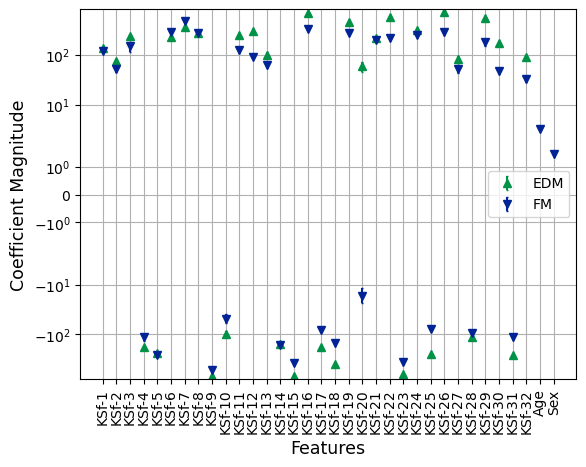

Likelihood Ratio Test
p-value [1. 1. 1. 1. 1.]
*********************


In [12]:
###inspection
if flag_comlete_model:
    
    ###sensitivity anlaysis paramters
    time_scales = {"AF": 0.1, "MI":0.2, "SB": 0.2}
    time_scale = time_scales[kind]
    nmax_time = 10*time_scale
    number_of_kshapes = 32
    C = 1e5
    kolors = sns.color_palette()
    kolors = {"AF": ["#009246", "#002395"], 
                     "MI":["#AA151B", "#00A1DE"], 
                      "SB": ["#000000", "#FF883E"]}
    
    kolors_plot = kolors[kind]
    
    smotenn = SMOTEENN(sampling_strategy=1)    
    ###get the most salient patterns
    most_salient_patterns = utils.Most_Salient_Pattern(Xtest[Ytest==1], 
                                                       SMs[Ytest==1].mean(axis= -1),
                                                       time_scale=time_scale)
    
    print(most_salient_patterns.shape)

    
    ###extract the Kpatterns
    kpattern, __ = utils.find_K_patterns(most_salient_patterns, number_of_kshapes)

    print(kpattern.shape)
    
    ###get the new features
    feat_min = utils.min_distance_feature(U, kpattern)
    
    print(feat_min.shape)
                                
    #transform the new features with a kernel PCA
    kpca = KernelPCA(n_components= number_of_kshapes, 
                            kernel= "rbf", 
                            fit_inverse_transform= True,
                            )
                
    feat = kpca.fit_transform(feat_min)

    ##use smoteenn if necessary
    try:
        new_x, new_y = smotenn.fit_resample(feat, V)
    except:
        new_x, new_y = feat.copy(), V.copy()
    
    ##use smoteen for the complete dataset (1-D CNN-derived + baseline)
    P = np.concatenate((feat, B_u), axis= 1)
    try:
        new_p, new_q = smotenn.fit_resample(P, V)
    except:
        new_p, new_q = P.copy(), V.copy()


    ####make prediction (AUROC) for ecg-derived features
    #new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(new_x, new_y, 
    #                                                                    train_size=.8,
    #                                                                   random_state=16)
    
    ks = KFold(n_splits=5, random_state=7, shuffle=True)
    metrics_ = []
    for index_train, index_test in ks.split(new_x):
        
        lr = LogisticRegression(C=C, fit_intercept=True, random_state=16)
        lr.fit(new_x[index_train], new_y[index_train])
        
        ###auc
        auc_ = roc_auc_score(y_score=lr.predict_proba(new_x[index_test])[:, 1], 
                             y_true= new_y[index_test])
        ##ap
        ap_ = average_precision_score(y_score=lr.predict_proba(new_x[index_test])[:, 1], 
                             y_true= new_y[index_test])
        ##
        mcc_ = matthews_corrcoef(y_pred= lr.predict(new_x[index_test]), y_true= new_y[index_test])
        
        ###
        ms3_ = auc_*ap_*.5*(1+mcc_)
        
        ###
        likelihood_ = log_loss(y_pred= lr.predict_proba(new_x[index_train])[:, 1], 
                              y_true= new_y[index_train])
        
        weights_ = lr.coef_.ravel()
        
        #####
        metrics_.append(np.hstack([auc_, ap_, mcc_, ms3_, likelihood_, weights_]))
        
    metrics = np.array(metrics_)
        
        
    print("Metrics ECG-Derived:", np.mean(metrics, axis= 0), stats.sem(metrics, axis= 0))
    
    ####INSPECTION
    
    ####plot results
    plt.figure(1)
    plt.errorbar(x = np.arange(32), 
                 y= metrics[:, 5:].mean(axis= 0), 
                 yerr= stats.sem(metrics[:, 5:]),
                 c= kolors_plot[0],
                 marker= "^", 
                 ls= 'None',
                 label= "EDM", 
                 capsize= 1.0)
    
    #####NOW CREATE A NEW MODEL INCLUDING THE BASELINE COVARIATES.
    #new_p_train, new_p_test, new_q_train, new_q_test = train_test_split(new_p, new_q, 
    #                                                                    train_size=.8,
    #                                                                    random_state=16)

    metrics_baseline = []
    for index_train, index_test in ks.split(new_p):
        
        lr_baseline = LogisticRegression(C=C, fit_intercept=True, random_state=16)
        lr_baseline.fit(new_p[index_train], new_q[index_train])
        
        ###auc
        auc_ = roc_auc_score(y_score=lr_baseline.predict_proba(new_p[index_test])[:, 1], 
                             y_true= new_q[index_test])
        ##ap
        ap_ = average_precision_score(y_score=lr_baseline.predict_proba(new_p[index_test])[:, 1], 
                             y_true= new_q[index_test])
        ##
        mcc_ = matthews_corrcoef(y_pred= lr_baseline.predict(new_p[index_test]), y_true= new_q[index_test])
        
        ###
        ms3_ = auc_*ap_*.5*(1+mcc_)
        
        ###
        likelihood_ = log_loss(y_pred= lr_baseline.predict_proba(new_p[index_train])[:, 1], 
                              y_true= new_q[index_train])
        
        weights_ = lr_baseline.coef_.ravel()
        
        #####
        metrics_baseline.append(np.hstack([auc_, ap_, mcc_, ms3_, likelihood_, weights_]))
        
    metrics_baseline = np.array(metrics_baseline)
        
        
    print("Metrics Full:", np.mean(metrics_baseline, axis= 0), stats.sem(metrics_baseline, axis= 0))
    
    #
    plt.errorbar(x = np.arange(34), 
                 y= metrics_baseline[:, 5:].mean(axis= 0), 
                 yerr= stats.sem(metrics_baseline[:, 5:]),
                 c= kolors_plot[1],
                 marker= "v", 
                 ls= 'None',
                 label= "FM", 
                 capsize= 1.0)
    plt.grid(True)
    plt.xticks(np.arange(0, 34, 1), ["KSf-"+str(kk+1) for kk in range(32)]+["Age", "Sex"], rotation= 90)
    plt.xlabel("Features", fontsize= 12.5)
    plt.ylabel("Coefficient Magnitude", fontsize= 12.5)
    plt.legend()
    plt.yscale('symlog')
    plt.savefig("Comparison_EDM_FM_"+str(kind)+".pdf")
    plt.show()    
    
    ### ### ###
    ####Likelihood ratio test
    likelihood_ecg = metrics[:, 4]
    likelihood_complete = metrics_baseline[:, 4]

    log_ratio_stat = -2*np.log(likelihood_ecg/likelihood_complete)

    ###One-Tail test. I want to see what is the p-value to reject the null hypothesis P(X>c)
    p_val = stats.chi2.sf(log_ratio_stat, df= 2)
    print("Likelihood Ratio Test")
    print("p-value", p_val)
    print("*********************")

0.5586708203530634

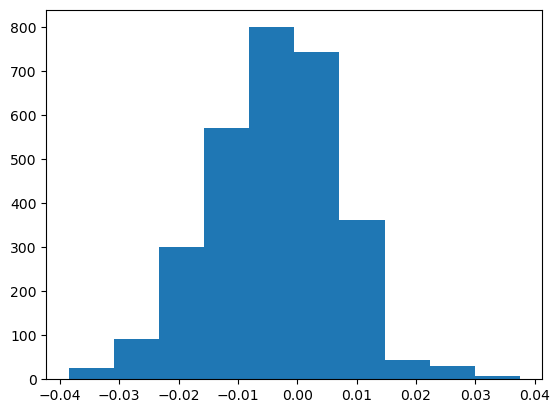

In [13]:
plt.hist(new_x[new_y==0, 0])
new_y.mean()

In [14]:
metrics[:, 5:].shape

(5, 32)